In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
%matplotlib inline

import os, pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

meta = unpickle("cifar100/meta")
# train = unpickle("cifar100/train")
# test = unpickle("cifar100/test")

### Load Labels Names From original CIFAR 100 Dataset

In [2]:
# meta.keys() : dict_keys([b'fine_label_names', b'coarse_label_names'])
# meta[b'fine_label_names'] : [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver'......]
label_names = [name.decode() for name in meta[b'fine_label_names']]
label_names[:5], len(label_names)

(['apple', 'aquarium_fish', 'baby', 'bear', 'beaver'], 100)

In [3]:
def myPicturePlotting(row, col, pictures:list[np.array], name_list=None):
    """
    can plot many pictures of images, and display names optionally
    """
    # length parsing
    length = len(pictures)
    
    # dimension checking
    if row*col < length:
        row = int(np.sqrt(length)) + 1
        col = row    
        
    fig, axs = plt.subplots(row, col, figsize=(10,10))

    idx = 0
    if row == 1:
        axs = [axs]
    if col == 1:
        axs = [axs]
    
    
    for r in range(row):
        for c in range(col):
            axs[r][c].imshow(pictures[idx])
            if name_list != None:
                axs[r][c].set_title(name_list[idx])
                
            axs[r][c].set_xticks([])
            axs[r][c].set_yticks([])
            idx += 1
            if length == idx:
                break
        if length == idx:
            break
    plt.show()
    
def normalize(img):
    return ((img / 255) - 0.5) / 0.5

def denormalize(img:np.ndarray):
    return ((img * 0.5) + 0.5) * 255

def imgChangeAxis(img:np.ndarray):
    """
    from (N, width, height, 3) to (N, 3, width, height)
    or (width, height, 3) to (3, width, height)
    """
    if len(img.shape) == 4:
        R = img[:,:,:,0]
        G = img[:,:,:,1]
        B = img[:,:,:,2]
        return np.stack((R,G,B),axis=1)
        
    elif len(img.shape) == 3:
        R = img[:,:,0]
        G = img[:,:,1]
        B = img[:,:,2]
        return np.stack((R,G,B))
    else:
        raise Exception("Dimension Not matching")
    
def imgDeChangeAxis(img:np.ndarray):
    """
    from (N, 3, width, height) to (N, width, height, 3)
    or (3, width, height) to (width, height, 3)
    """
    if len(img.shape) == 4:
        return np.stack((img[:,0],img[:,1],img[:,2]), axis=-1)
    elif len(img.shape) == 3:
        return np.stack((img[0],img[1],img[2]), axis=-1)
 

### Load Image Data (with labels) and turn into np array

In [4]:
img_list = []
label_list = []
name_list = []

for name in os.listdir("./eval"):
    filename = name.split(".")[0]
    label, index = [int(x) for x in filename.split("_")]
    if index >= 2:
        continue
    
    path = f"eval/{name}"
    img = imgChangeAxis(np.array(Image.open(path))) 
    img_list.append(img)
    label_list.append(label)
    name_list.append(name)
    
print(img_list[0].shape) #,myPicturePlotting(1,1,[imgDeChangeAxis(img_list[0])])

(3, 32, 32)


# Model Part

#### Simple Transformer & prepare the images and labels (turn into tensor and put into GPU)

In [5]:
import torch

device = "cuda"
# I use my normalize function :)

img_tensor = normalize(torch.tensor(np.stack(img_list))).to(torch.float32).to(device)

label_tensor = torch.tensor(np.stack(label_list)).to(torch.int64).to(device)


# userful for clear cache
def myStrongCacheClear(func):
    def wrapper(*args, **kwargs):
        with torch.no_grad():
            func(*args, **kwargs)
            torch.cuda.empty_cache()
    return wrapper

def myATKCacheClear(func):
    def wrapper(*args, **kwargs):
        func(*args, **kwargs)
        torch.cuda.empty_cache()
    return wrapper

In [6]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch

resnet20 = ptcv_get_model("resnet20_cifar100", pretrained=True).cuda().eval()

### Extend DeepFool attack of torchattacks from L2 to L inf

In [7]:
from torchattacks.attack import Attack

import torch
import torch.nn as nn

class myDeepFool(Attack):
    r"""
    'DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks'
    [https://arxiv.org/abs/1511.04599]
    Distance Measure : L2 ( torchattacks version )
    Distance Measure : L inf ( My version )
    Arguments:
        model (nn.Module): model to attack.
        steps (int): number of steps. (Default: 50)
        overshoot (float): parameter for enhancing the noise. (Default: 0.02)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, steps=50, overshoot=0.02):
        super().__init__("DeepFool", model)
        self.steps = steps
        self.overshoot = overshoot
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        adv_images, target_labels = self.forward_return_target_labels(images, labels)
        return adv_images

    def forward_return_target_labels(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        batch_size = len(images)
        correct = torch.tensor([True] * batch_size)
        target_labels = labels.clone().detach().to(self.device)
        curr_steps = 0

        adv_images = []
        # notice that we only pass one img into deepfool
        for idx in range(batch_size):
            image = images[idx : idx + 1].clone().detach()
            adv_images.append(image)

        while (True in correct) and (curr_steps < self.steps):
            for idx in range(batch_size):
                if not correct[idx]:
                    continue
                early_stop, pre, adv_image = self._forward_indiv(
                    adv_images[idx], labels[idx]
                )
                adv_images[idx] = adv_image
                target_labels[idx] = pre
                if early_stop:
                    correct[idx] = False
            curr_steps += 1

        if curr_steps == self.steps:
            raise Exception("not Converge")
        
        adv_images = torch.cat(adv_images).detach()
        return adv_images, target_labels

    def _forward_indiv(self, image, label):
        image.requires_grad = True
        fs = self.get_logits(image)[0]
        _, pre = torch.max(fs, dim=0)
        if pre != label:
            return (True, pre, image)

        ws = self._construct_jacobian(fs, image)
        image = image.detach()

        f_0 = fs[label]
        w_0 = ws[label]

        wrong_classes = [i for i in range(len(fs)) if i != label]
        f_k = fs[wrong_classes]
        w_k = ws[wrong_classes]

        f_prime = f_k - f_0
        w_prime = w_k - w_0
        # value = torch.abs(f_prime) / torch.norm(nn.Flatten()(w_prime), p=2, dim=1)
        value = torch.abs(f_prime) / torch.norm(nn.Flatten()(w_prime), p = 1, dim=1)
        _, hat_L = torch.min(value, 0)

        # delta = (
        #     torch.abs(f_prime[hat_L])
        #     * w_prime[hat_L]
        #     / (torch.norm(w_prime[hat_L], p=2) ** 2)
        # )
        
        delta = (
            torch.abs(f_prime[hat_L])
            * torch.sign(w_prime[hat_L])
            / torch.norm(w_prime[hat_L], p = 1)
        )

        target_label = hat_L if hat_L < label else hat_L + 1

        adv_image = image + (1 + self.overshoot) * delta
        adv_image = torch.clamp(adv_image, min=0, max=1).detach()
        return (False, target_label, adv_image)

    # https://stackoverflow.com/questions/63096122/pytorch-is-it-possible-to-differentiate-a-matrix
    # torch.autograd.functional.jacobian is only for torch >= 1.5.1
    def _construct_jacobian(self, y, x):
        x_grads = []
        for idx, y_element in enumerate(y):
            if x.grad is not None:
                x.grad.zero_()
            y_element.backward(retain_graph=(False or idx + 1 < len(y)))
            x_grads.append(x.grad.clone().detach())
        return torch.stack(x_grads).reshape(*y.shape, *x.shape)


In [8]:
temp = myDeepFool(resnet20.cuda(), steps=20, overshoot=0.02)
temp.set_device('cuda')
temp.set_normalization_used(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
adv = temp(img_tensor[:1], label_tensor[:1])
adv.min(), adv.max()

(tensor(-1., device='cuda:0'), tensor(1., device='cuda:0'))

### modify UAT from tensorflow to pytorch

In [9]:
def proj_lp(v, xi, p):
    return torch.sign(v) * torch.minimum(torch.abs(v), torch.ones(v.shape).to('cuda') * xi)

    # Project on the lp ball centered at 0 and of radius xi

    # SUPPORTS only p = 2 and p = Inf for now
    # if p == 2:
    #     v = v * min(1, xi/np.linalg.norm(v.flatten(1)))
    #     # v = v / np.linalg.norm(v.flatten(1)) * xi
    # elif p == np.inf:
    #     v = np.sign(v) * np.minimum(abs(v), xi)
    # else:
    #      raise ValueError('Values of p different from 2 and Inf are currently not supported...')

    # return v

def universal_perturbation(img_tensor, label_tensor, model:nn.Module, delta=0.2, max_iter_uni = np.inf, xi = 10 / 255 / 0.5, p=np.inf, overshoot=0.02, max_iter_df=10):
    """
    :param dataset: Images of size MxHxWxC (M: number of images)

    :param model: feedforward function i.e. model (input: images, output: values of activation BEFORE softmax).

    :param grads: gradient functions with respect to input (as many gradients as classes).

    :param delta: controls the desired fooling rate (default = 80% fooling rate)

    :param max_iter_uni: optional other termination criterion (maximum number of iteration, default = np.inf)

    :param xi: controls the l_p magnitude of the perturbation (default = 10)

    :param p: norm to be used (FOR NOW, ONLY p = 2, and p = np.inf ARE ACCEPTED!) (default = np.inf)

    :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).

    :param max_iter_df: maximum number of iterations for deepfool (default = 10)

    :return: the universal perturbation.
    """

    deepfool = myDeepFool(model.cuda(), steps=max_iter_df, overshoot=overshoot)
    deepfool.set_device('cuda')
    deepfool.set_normalization_used(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    
    v = 0
    fooling_rate_list = []
    fooling_rate = 0.0
    N, _, _,_ =  img_tensor.shape # The images should be stacked ALONG FIRST DIMENSION

    iter = 0
    while fooling_rate < 1-delta and iter < max_iter_uni:
        # Shuffle the dataset
        # torch.random.shuffle(dataset)
        bag_size = int(N / 1)
        img = img_tensor[np.random.choice(N, bag_size)]

        print (f'Iter:{iter}',end='\r')

        # Go through the data set and compute the perturbation increments sequentially
        for k in range(0, bag_size):
            cur_img = img[k:(k+1), :, :, :]
            true_label = label_tensor[k:(k+1)].item()
            model_pred = torch.argmax(model(cur_img)).item()
            pert_pred = torch.argmax(model(cur_img + v)).item()
            # if model_pred != true_label:
                # print(f"already diff:{model_pred},{true_label}")
                # continue
            if model_pred == pert_pred:
                # print('>> k = ', k, ', pass #', iter)

                # Compute adversarial perturbation
                try:
                    adv = deepfool(cur_img + v, label_tensor)
                    dr = adv - cur_img
                    v = v + dr
                    v = proj_lp(v, xi, p)
                except Exception as e:
                    print(e)
                    pass # not converged

        iter = iter + 1

        model.eval()
        model.cuda()
        correct_num = 0
        idx = 0
        while idx < len(label_tensor):
            correct_num += torch.eq(torch.argmax(model(img_tensor[idx:idx+64] + v), dim=1), label_tensor[idx:idx+64]).sum().item()
            idx += 64
        fooling_rate = 1 - correct_num / N
        fooling_rate_list.append(fooling_rate)
        print('FOOLING RATE = ', fooling_rate)

    return v, iter, fooling_rate_list

In [28]:
# temp = myDeepFool(resnet20.cuda(), steps=20, overshoot=0.02)
# temp.set_device('cuda')
# temp.set_normalization_used(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
# temp(img_tensor[0:1], label_tensor[0:1])

### Start 5 attacks

In [ ]:
v1, iter, fooling_rate_list1 = universal_perturbation(img_tensor, label_tensor, resnet20, delta = 0.01, max_iter_uni = 10, xi = 12 / 255 / 0.5, overshoot = 0.005, max_iter_df = 20)
v2, iter, fooling_rate_list2 = universal_perturbation(img_tensor, label_tensor, resnet20, delta = 0.01, max_iter_uni = 10, xi = 12 / 255 / 0.5, overshoot = 0.005, max_iter_df = 20)
v3, iter, fooling_rate_list3 = universal_perturbation(img_tensor, label_tensor, resnet20, delta = 0.01, max_iter_uni = 10, xi = 12 / 255 / 0.5, overshoot = 0.005, max_iter_df = 20)
v4, iter, fooling_rate_list4 = universal_perturbation(img_tensor, label_tensor, resnet20, delta = 0.01, max_iter_uni = 10, xi = 12 / 255 / 0.5, overshoot = 0.005, max_iter_df = 20)
v5, iter, fooling_rate_list5 = universal_perturbation(img_tensor, label_tensor, resnet20, delta = 0.01, max_iter_uni = 10, xi = 12 / 255 / 0.5, overshoot = 0.005, max_iter_df = 20)

In [23]:
# torch.argmax(resnet20(img_tensor + v1), dim=1)

### plotting out result

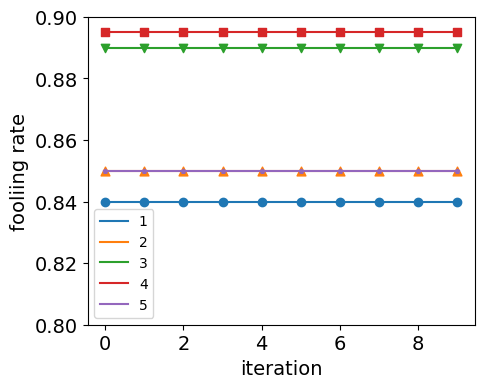

In [126]:
plt.figure(figsize=(5,4))
plt.ylim([0.8,0.9])
plt.ylabel("fooliing rate", fontsize=14)
plt.xlabel("iteration", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.plot(range(iter),fooling_rate_list1, label="1")
plt.scatter(range(iter),fooling_rate_list1, marker='o')
plt.plot(range(iter),fooling_rate_list2, label="2")
plt.scatter(range(iter),fooling_rate_list2, marker='^', s=40)
plt.plot(range(iter),fooling_rate_list3, label="3")
plt.scatter(range(iter),fooling_rate_list3, marker='v')
plt.plot(range(iter),fooling_rate_list4, label="4")
plt.scatter(range(iter),fooling_rate_list4, marker='s')
plt.plot(range(iter),fooling_rate_list5, label="5")
plt.scatter(range(iter),fooling_rate_list5, marker='p', s=10)
plt.legend()

### Save pertubation

In [42]:
pert = (v1.cpu().numpy() * 0.5) * 255 + 12
pert_img = Image.fromarray(imgDeChangeAxis(pert).astype(np.uint8)[0])
pert_img.save("universal.png")


### Checking

In [47]:
pert_check = imgChangeAxis(np.array(Image.open("universal.png"))).astype(np.int16)
pert_check.shape

(3, 32, 32)

In [48]:
v = (torch.tensor(pert_check).reshape(1,3,32,32).cuda() - 12) / 255 / 0.5
v

tensor([[[[-0.0941, -0.0941, -0.0941,  ..., -0.0941,  0.0941,  0.0941],
          [ 0.0941, -0.0941,  0.0941,  ...,  0.0941,  0.0941, -0.0941],
          [ 0.0941,  0.0941,  0.0941,  ...,  0.0941, -0.0941, -0.0941],
          ...,
          [ 0.0941,  0.0941, -0.0941,  ...,  0.0941, -0.0941, -0.0941],
          [ 0.0941,  0.0941, -0.0941,  ...,  0.0941, -0.0941,  0.0941],
          [-0.0941, -0.0941, -0.0941,  ..., -0.0941,  0.0941,  0.0941]],

         [[ 0.0941,  0.0941, -0.0941,  ..., -0.0941,  0.0941,  0.0941],
          [ 0.0941, -0.0941, -0.0941,  ..., -0.0941,  0.0941,  0.0941],
          [-0.0941,  0.0941,  0.0941,  ...,  0.0941,  0.0941,  0.0941],
          ...,
          [ 0.0941,  0.0941,  0.0941,  ...,  0.0941, -0.0941, -0.0941],
          [ 0.0941,  0.0941, -0.0941,  ...,  0.0941, -0.0941,  0.0941],
          [-0.0941, -0.0941,  0.0941,  ..., -0.0941,  0.0941, -0.0941]],

         [[-0.0941,  0.0941,  0.0941,  ...,  0.0941, -0.0941,  0.0941],
          [-0.0941, -0.0941, -

In [49]:
model = resnet20.cuda().eval()
correct_num = 0
idx = 0
while idx < len(label_tensor):
    correct_num += torch.eq(torch.argmax(model(img_tensor[idx:idx+64] + v), dim=1), label_tensor[idx:idx+64]).sum().item()
    idx += 64
fooling_rate = 1 - correct_num / 200
fooling_rate

0.89